In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import sklearn as sk
from sklearn import preprocessing as pre

In [30]:
GO='<go>'
STOP='<stop>'
PAD='<pad>'
BATCH=250
ATTEND=True
BEAM=False
BEAM_WIDTH=5
EPOCHS=10

In [6]:
def breaker(listofsentences,start=True):
    '''returns a list of list of strings'''
    if listofsentences==None:
        return None
    lst=[]
    for i in listofsentences:
        t=i.split()
        if start:
            t=[GO]+t+[PAD]
        else:
            t=[GO]+t+[STOP]
        lst.append(t)
    return lst

In [7]:
def read(data='train'):
    COMBINED='./WeatherGov/'+data+'/'+data+'.combined'
    SUMMARY='./WeatherGov/'+data+'/summaries.txt'
    op_sec=None
    with open(COMBINED) as f:
        content = f.readlines()
    ip_sec = [x.strip() for x in content]
    if data!='test':
        with open(SUMMARY) as f:
            content = f.readlines()
        op_sec = [x.strip() for x in content]
        
    return breaker(ip_sec,True),breaker(op_sec,False)

In [8]:
def listofwords(data):
    '''takes a list of sentences nd returns vocab'''
    a=[]
    for i in data:
        for j in i:
            if j not in a:
                a.append(j)
    return a

In [9]:
training_ip_sec,training_op_sec=read('train')
valid_ip_sec,valid_op_sec=read('dev')
test_ip_sec,_=read('test')

In [10]:
ip_vocab=listofwords(training_ip_sec)
op_vocab=listofwords(training_op_sec)

In [11]:
ip_vocab_size,op_vocab_size=len(ip_vocab),len(op_vocab)

In [12]:
training_ip_sec_len=[len(i) for i in training_ip_sec]
training_op_sec_len=[len(i) for i in training_op_sec]
valid_ip_sec_len=[len(i) for i in valid_ip_sec]
valid_op_sec_len=[len(i) for i in valid_op_sec]
test_ip_sec_len=[len(i) for i in test_ip_sec]

In [13]:
pre_ip=pre.LabelEncoder()
pre_ip.fit(ip_vocab)

onehoter=np.identity(len(pre_ip.classes_))

#word to int
training_ip_sect=[pre_ip.transform(i) for i in training_ip_sec]
valid_ip_sect=[pre_ip.transform(i) for i in valid_ip_sec]
test_ip_sect=[pre_ip.transform(i) for i in test_ip_sec]

#adding pads
maxi=0
for i in training_ip_sect:
    maxi=max(maxi,len(i))
training_ip_sect0=[np.pad(i,(0,maxi-len(i)),'constant',constant_values=pre_ip.transform([PAD])) for i in training_ip_sect]
valid_ip_sect0=[np.pad(i,(0,maxi-len(i)),'constant',constant_values=pre_ip.transform([PAD])) for i in valid_ip_sect]
test_ip_sect0=[np.pad(i,(0,maxi-len(i)),'constant',constant_values=pre_ip.transform([PAD])) for i in test_ip_sect]

#making them onehot
training_ip_sectt=[[onehoter[i] for i in j] for j in training_ip_sect0]
valid_ip_sectt=[[onehoter[i] for i in j] for j in valid_ip_sect0]
test_ip_sectt=[[onehoter[i] for i in j] for j in test_ip_sect0]


#del training_ip_sec,valid_ip_sec,test_ip_sec
#del training_ip_sect,valid_ip_sect,test_ip_sect
#del training_ip_sect0,valid_ip_sect0,test_ip_sect0

#OP sec
pre_op=pre.LabelEncoder()
pre_op.fit(op_vocab)

onehoter2=np.identity(len(pre_op.classes_))

#word to int
training_op_sect=[pre_op.transform(i) for i in training_op_sec]
valid_op_sect=[pre_op.transform(i) for i in valid_op_sec]

#adding pad
maxi=0
for i in training_op_sect:
    maxi=max(maxi,len(i))
training_op_sect0=[np.pad(i,(0,maxi-len(i)),'constant',constant_values=pre_op.transform([STOP])) for i in training_op_sect]
valid_op_sect0=[np.pad(i,(0,maxi-len(i)),'constant',constant_values=pre_op.transform([STOP])) for i in valid_op_sect]


#int to onehot
training_op_sectt=[[onehoter2[i] for i in j] for j in training_op_sect0]
valid_op_sectt=[[onehoter2[i] for i in j] for j in valid_op_sect0]

training_op_sectt_nopad=[[onehoter2[i] for i in j] for j in training_op_sect]
valid_op_sectt_nopad=[[onehoter2[i] for i in j] for j in valid_op_sect]


del training_op_sec,valid_op_sec
del training_op_sect,valid_op_sect
#del training_op_sect0,valid_op_sect0


In [14]:
maxi=0
for i in training_op_sect0:
    maxi=max(maxi,len(i))
print maxi

90


In [15]:
#using sect
embedding_size=256
lstm_units=128
tf.reset_default_graph()

In [16]:
source_seq = tf.placeholder(shape=(None, None), dtype=tf.int32)
target_seq = tf.placeholder(shape=(None, None), dtype=tf.int32)
source_seq_len = tf.placeholder(shape=(None,), dtype=tf.int32)
target_seq_len = tf.placeholder(shape=(None,), dtype=tf.int32)
no_start_target_seq = tf.placeholder(shape=(None, None), dtype=tf.int32)
trainer = tf.placeholder(shape=(None),dtype=tf.bool)
batch_size = tf.placeholder(shape=(None),dtype=tf.int32)
real_target_seq_len= tf.placeholder(shape=(None,), dtype=tf.int32)

In [17]:
embedding_matrix_encode = tf.get_variable(
    name="embedding_matrix_en",
    shape=[ip_vocab_size, embedding_size],
    dtype=tf.float32)
embedding_matrix_decode = tf.get_variable(
    name="embedding_matrix_de",
    shape=[op_vocab_size, embedding_size],
    dtype=tf.float32)
source_seq_embedded = tf.nn.embedding_lookup(embedding_matrix_encode, source_seq) 
decoder_input_embedded = tf.nn.embedding_lookup(embedding_matrix_decode, target_seq) 

In [18]:
(encoder_outputs_fw,encoder_outputs_bw) ,(encoder_state_fw,encoder_state_bw) = tf.nn.bidirectional_dynamic_rnn(
    tf.contrib.rnn.LSTMCell(lstm_units),tf.contrib.rnn.LSTMCell(lstm_units),
    source_seq_embedded,
    sequence_length=source_seq_len,
    dtype=tf.float32)


In [19]:
attention_states=tf.concat((encoder_outputs_fw,encoder_outputs_bw),1)
attention_mechanism = tf.contrib.seq2seq.LuongAttention(lstm_units*2, attention_states,)

In [20]:
encoder_final_state_c = tf.layers.dropout(inputs=tf.concat(
    (encoder_state_fw.c, encoder_state_bw.c), 1),rate=0.4,training=trainer)

encoder_final_state_h = tf.layers.dropout(inputs=tf.concat(
    (encoder_state_fw.h, encoder_state_bw.h), 1),rate=0.4,training=trainer)

encoder_final_state = tf.contrib.rnn.LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)


In [21]:
output_layer = tf.layers.Dense(op_vocab_size)

decoder_cell=tf.contrib.rnn.LSTMCell(lstm_units*2)


In [22]:
decoder_initial_state=encoder_final_state

In [23]:

if ATTEND:
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
        decoder_cell, attention_mechanism,
        attention_layer_size=lstm_units*2,alignment_history=True)


In [24]:
if ATTEND:
    decoder_initial_state = decoder_cell.zero_state(BATCH, tf.float32)#.clone(cell_state=decoder_initial_state)

In [25]:

helper = tf.contrib.seq2seq.TrainingHelper(decoder_input_embedded,target_seq_len)
decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, helper, initial_state=decoder_initial_state,output_layer=output_layer)#,output_layer=projection_layer)
outputs, state, seq_len = tf.contrib.seq2seq.dynamic_decode(decoder)
logits = outputs.rnn_output


In [89]:
helper2 = tf.contrib.seq2seq.GreedyEmbeddingHelper(embedding_matrix_decode,tf.fill([batch_size],
                                                    np.int32(pre_op.transform([GO])[0])),
                                                   np.int32(pre_op.transform([STOP])[0]))


decoder2 = tf.contrib.seq2seq.BasicDecoder(decoder_cell, helper2, decoder_initial_state,output_layer=output_layer)#,output_layer=projection_layer)

outputs, state, seq_len = tf.contrib.seq2seq.dynamic_decode(decoder2,maximum_iterations=maxi+10)

translations_logits = outputs.rnn_output
trs=outputs.sample_id

In [90]:
##beam
if BEAM:
    decoder_initial_state_beam = tf.contrib.seq2seq.tile_batch(
        decoder_initial_state, multiplier=BEAM_WIDTH)

    # Define a beam-search decoder
    decoder3 = tf.contrib.seq2seq.BeamSearchDecoder(
            cell=decoder_cell,
            embedding=embedding_matrix_decode,
            start_tokens=tf.fill([batch_size],np.int32(pre_op.transform([GO])[0])),
            end_token=np.int32(pre_op.transform([STOP])[0]),
            initial_state=decoder_initial_state_beam,
            beam_width=BEAM_WIDTH,
            output_layer=output_layer,
            length_penalty_weight=0.0)
    outputs, state, seq_len = tf.contrib.seq2seq.dynamic_decode(decoder3,maximum_iterations=maxi+10)


    trs_beam=outputs.predicted_ids


In [26]:
cross_entropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=no_start_target_seq,logits=logits)

target_weights = tf.sequence_mask(real_target_seq_len, target_seq_len[0], dtype=logits.dtype)

loss=tf.reduce_sum(cross_entropy*target_weights)
train = tf.train.AdamOptimizer().minimize(loss)


In [27]:
maxtlen=max(training_op_sec_len)
maxvlen=max(valid_op_sec_len)
t_newlen=[maxtlen-1 for i in range(len(training_op_sec_len))]
v_newlen=[maxtlen-1 for i in range(len(valid_op_sec_len))]

In [28]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [31]:
training_losses=[]
valid_losses=[]
for j in range(EPOCHS):
    training_loss=0
    for i in range(len(training_ip_sectt)/BATCH):
        start=i*BATCH
        stop=(i+1)*BATCH
        
        _,lost=sess.run([train,loss],feed_dict={source_seq:training_ip_sect0[start:stop],
                                                target_seq:training_op_sect0[start:stop],
                                              source_seq_len:training_ip_sec_len[start:stop],
                                                target_seq_len:t_newlen[start:stop],
                                                real_target_seq_len:training_op_sec_len[start:stop],
                                                no_start_target_seq:np.array(training_op_sect0[start:stop])[:,1:],
                                                batch_size:BATCH,
                                                trainer:True
                                                })
        
        #print i,lost
        
        training_loss+=lost
        
    #calculate t_loss
    training_losses.append(training_loss/len(training_ip_sectt))
    
    #calculate v_loss
    validation_loss=0
    for k in range(len(valid_ip_sectt)/BATCH):
        start=k*BATCH
        stop=(k+1)*BATCH

        lost=sess.run(loss,feed_dict={source_seq:valid_ip_sect0[start:stop],
                                                target_seq:valid_op_sect0[start:stop],
                                              source_seq_len:valid_ip_sec_len[start:stop],
                                                target_seq_len:v_newlen[start:stop],
                                                    real_target_seq_len:valid_op_sec_len[start:stop],
                                                    no_start_target_seq:np.array(valid_op_sect0[start:stop])[:,1:],
                                                    batch_size:BATCH,
                                                    trainer:False})
        validation_loss += lost
        
    valid_losses.append(validation_loss/len(valid_ip_sectt))
    print "Epoch:%d training loss%.4f: valid loss:%.4f"% (j,training_losses[-1],valid_losses[-1])

Epoch:0 training loss32.6707: valid loss:24.3973
Epoch:1 training loss21.9032: valid loss:19.8764
Epoch:2 training loss18.3198: valid loss:16.6355
Epoch:3 training loss15.5108: valid loss:14.1860
Epoch:4 training loss13.5956: valid loss:12.7481
Epoch:5 training loss12.1600: valid loss:11.6212
Epoch:6 training loss11.1516: valid loss:10.6956
Epoch:7 training loss10.3050: valid loss:10.0334
Epoch:8 training loss9.6062: valid loss:9.4719
Epoch:9 training loss9.0496: valid loss:8.9596


In [ ]:
filer=open('./losses_b250.txt','w+')
for tl,vl in zip(training_losses,valid_losses):
    filer.write("%f,%f\n" % (tl,vl))
filer.close()

In [97]:
attention_images =tf.transpose(state.alignment_history.stack(), [1, 2, 0])
#attention_images *= 255

In [98]:
start,stop=0,250

In [105]:
alignments,y= sess.run([attention_images,outputs.sample_id], feed_dict={source_seq:valid_ip_sect0[start:stop],
                                                target_seq:valid_op_sect0[start:stop],
                                              source_seq_len:valid_ip_sec_len[start:stop],
                                                target_seq_len:t_newlen[start:stop],
                                                real_target_seq_len:valid_op_sec_len[start:stop],
                                                no_start_target_seq:np.array(valid_op_sect0[start:stop])[:,1:],
                                                batch_size:BATCH,
                                                trainer:False
                                                })

In [133]:
import matplotlib.pyplot as plt
%pylab inline
def plot_attention(attention_map, input_tags = None, output_tags = None):    
    
    # input_tags - word representation of input sequence, use None to skip
    # output_tags - word representation of output sequence, use None to skip
    # i - index of input element in batch
    
    attn_len = len(attention_map)
    shapeofmap=attention_map.shape
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(20, 30))
    ax = f.add_subplot(1, 1, 1)

    # Add image
    i = ax.imshow(attention_map, cmap='Blues')

    # Add colorbar
    cbaxes = f.add_axes([0.2, 0.35, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # Add labels
    ax.set_yticks(range(shapeofmap[0]))
    if output_tags is not None:
        ax.set_yticklabels(output_tags)

    ax.set_xticks(range(shapeofmap[1]))
    if input_tags is not None:
        ax.set_xticklabels(input_tags, rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()
    plt.savefig('x.eps',format='eps')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<Figure size 432x288 with 0 Axes>

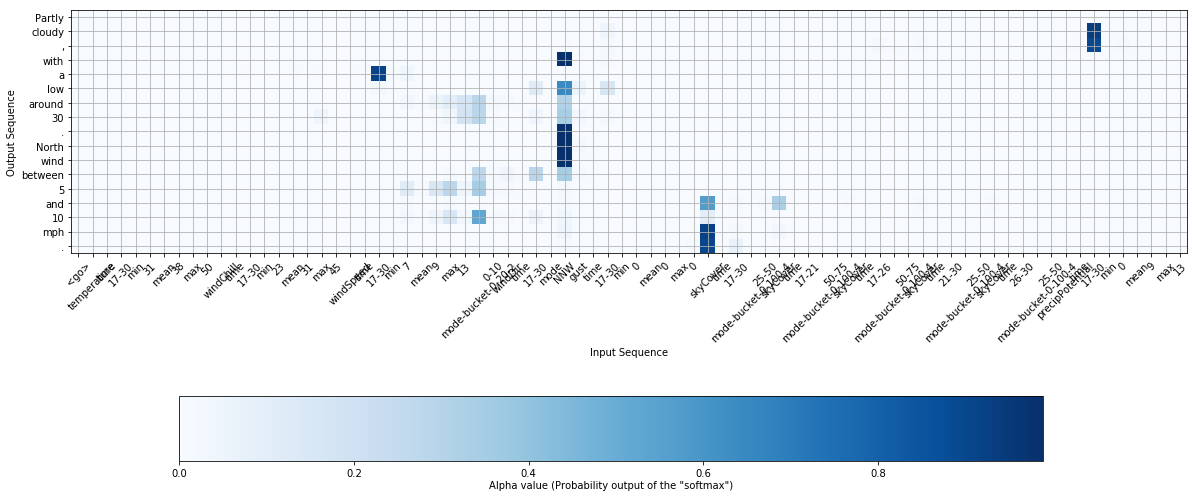

In [134]:
#plt.imsave('t1.eps',alignments[0,:77,:19].T,format='eps')
#print pre_op.inverse_transform(training_op_sect0[1])
plot_attention(alignments[1,:78,:17].T,pre_ip.inverse_transform(valid_ip_sect0[1][:78]),
               pre_op.inverse_transform(y[1,:17]))

x,y=sess.run([translations_logits,trs],feed_dict={source_seq:training_ip_sect0[0:BATCH],
                                               source_seq_len:training_ip_sec_len[0:BATCH],
                                           trainer:False,batch_size:BATCH
                                                })

pre_op.inverse_transform(y[0])

pre_op.inverse_transform(valid_op_sect0[0])

In [ ]:
data=test_ip_sect0
data_len=test_ip_sec_len
gen_sum=[]
for i in range(1):#len(data)/BATCH):
    start=i*BATCH
    stop=(i+1)*BATCH
    y=sess.run(trs_beam,feed_dict={source_seq:data[start:stop],
                                               source_seq_len:data_len[start:stop],
                                              batch_size:BATCH,
                                                    trainer:False
                                                })
    for t in y:
        gen_sum.append(t)

In [ ]:
y[0][:,0]

In [ ]:
summs=[]
for i in gen_sum:
    summ=''
    for j in i:
        
        if j!=205:
            summ = summ+' '+pre_op.inverse_transform(j)
    summs.append(summ[1:])

In [ ]:
filer=open('./model-1_test','w+')
for item in summs:
    filer.write("%s\n" % item)
filer.close()

In [ ]:
start,stop=0,2

In [ ]:

v_newlen[1000:1020]

In [ ]:
x,y=sess.run([target_seq,logits],feed_dict={source_seq:training_ip_sect0[start:stop],
                                                target_seq:training_op_sect0[start:stop],
                                              source_seq_len:training_ip_sec_len[start:stop],
                                                target_seq_len:v_newlen[start:stop],
                                                
                                                })

In [ ]:
pre_op.inverse_transform([x[1],np.argmax(y[1],axis=1)])

In [ ]:
len(training_ip_sect0[1000:1020])

In [ ]:
len(v_newlen)

In [ ]:
np.array(training_op_sect0)[:,1:]

In [ ]:
#saver = tf.train.Saver()
#saver.save(sess, './model/batch',global_step=1000)

In [ ]:
saver = tf.train.import_meta_graph('./model/batch-1000.meta')
saver.restore(sess,tf.train.latest_checkpoint('./model/'))

In [ ]:
dummy_ip=[]
for i in range(len(pre_ip.classes_)):
    dummy_ip.append(pre_ip.inverse_transform([i])[0])

In [ ]:
filer=open('./pre_ip.txt','w+')
for tl in dummy_ip:
    filer.write("%s\n" % tl)
    print tl
filer.close()

In [ ]:
dummy_op